In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import data,filters
import scipy.ndimage as ndimage
import numpy as np
from PIL import Image
from math import floor, ceil
import cv2
import os
import math
import pandas as pd
import random
import signal

class Timeout():
    """Timeout class using ALARM signal."""
    class Timeout(Exception):
        pass
 
    def __init__(self, sec):
        self.sec = sec
 
    def __enter__(self):
        signal.signal(signal.SIGALRM, self.raise_timeout)
        signal.alarm(self.sec)
 
    def __exit__(self, *args):
        signal.alarm(0)    # disable alarm
 
    def raise_timeout(self, *args):
        raise Timeout.Timeout()

# Question 1
## 1a

In [2]:
def H_matrix(theta, s, x0, y0, t0=None, t1=None):
    return np.array([[s*math.cos(theta),-s*math.sin(theta), -(math.cos(theta)*x0+ math.sin(theta)*y0-x0)],
                    [s*math.sin(theta),s*math.cos(theta),-(math.sin(theta)*x0+ math.cos(theta)*y0-x0)],
                    [0,0,1]])
def H_matrix_t(theta, s, x0, y0, t0, t1):
    return np.array([[s*math.cos(theta),-s*math.sin(theta),t1],
                    [s*math.sin(theta),s*math.cos(theta),t1],
                    [0,0,1]])

## 1b
Apply the homography H from part (a) to a colour image of your choosing, for two or three different
choices of θ and s. You will find a document in the accompanying material detailing how an image
can be transformed with a given homography.

In [3]:
def apply_homography(a, h):
    r, c, col = np.shape(a)
    # Determine size of output image by forward-transforming the four corners of A
    p1_h, p2_h, p3_h, p4_h = np.array([[0], [0], [1]], dtype=np.float), \
                             np.array([[c - 1], [0], [1]], dtype=np.float), \
                             np.array([[0], [r - 1], [1]], dtype=np.float), \
                             np.array([[c - 1], [r - 1], [1]], dtype=np.float)

    # Apply homography on each point
    p1, p2, p3, p4 = np.dot(h, p1_h), np.dot(h, p2_h), np.dot(h, p3_h), np.dot(h, p4_h)
    p1, p2, p3, p4 = p1 / p1[2, 0], p2 / p2[2, 0], p3 / p3[2, 0], p4 / p4[2, 0]

    # Get new min and max from each axis
    min_x = floor(min([p1[0, 0], p2[0, 0], p3[0, 0], p4[0, 0]]))
    max_x = ceil(max([p1[0, 0], p2[0, 0], p3[0, 0], p4[0, 0]]))
    min_y = floor(min([p1[1, 0], p2[1, 0], p3[1, 0], p4[1, 0]]))
    max_y = ceil(max([p1[1, 0], p2[1, 0], p3[1, 0], p4[1, 0]]))

    # Obtain new row and column
    nr, nc = max_y - min_y + 1, max_x - min_x + 1
    b = np.zeros([int(nr), int(nc), int(col)]) + 255
    h_inv = np.linalg.inv(h)
    for y in range(int(nr)):
        for x in range(int(nc)):
            p = np.array([[x + min_x], [y + min_y], [1]])
            pp = np.dot(h_inv, p)

            xp, yp = pp[0, 0] / pp[2, 0], pp[1, 0] / pp[2, 0]

            xpf, ypf = int(floor(xp)), int(floor(yp))
            xpc, ypc = xpf + 1, ypf + 1

            if (xpf >= 0) and (xpc < c) and (ypf >= 0) and (ypc < r):
                b[y, x, :] = ((xpc - xp) * (ypc - yp) * a[ypf, xpf, :]
                              + (xpc - xp) * (yp - ypf) * a[ypc, xpf, :]
                              + (xp - xpf) * (ypc - yp) * a[ypf, xpc, :]
                              + (xp - xpf) * (yp - ypf) * a[ypc, xpc, :])

    return b.astype(np.uint8)

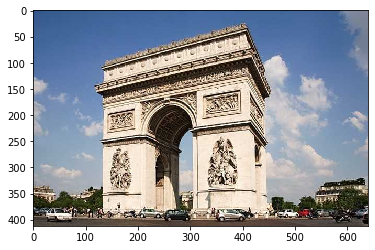

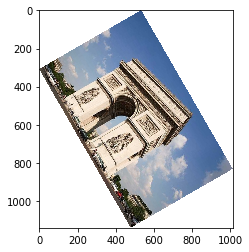

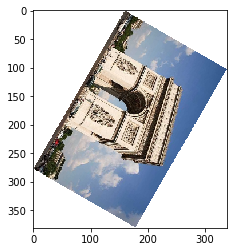

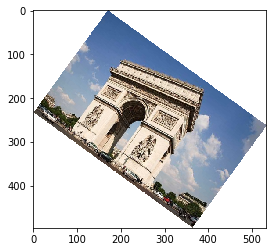

In [4]:
theta = np.pi/3
s = 1.5
H = H_matrix(theta,s,0,0)
A = plt.imread("arc.jpg")
plt.imshow(A)
plt.show()

B = apply_homography(A, H)
plt.imshow(B)
plt.show()

theta = 2*np.pi/3
s = 0.5
H = H_matrix(theta,s,0,0)
B = apply_homography(A, H)
plt.imshow(B)
plt.show()

theta = 0.2*np.pi
s = 0.7
H = H_matrix(theta,s,0,0)
B = apply_homography(A, H)
plt.imshow(B)
plt.show()

## 1c
If the procedure in that document is followed, why would different values for the translation component
in H (the last column’s first two entries) have no effect on the output image? Also, if θ > 0, why is
the image rotated clockwise even though the form of R suggests counterclockwise rotation?

# Question 2
## 2a
Paste a poster of your favourite movie onto the side of the building in griest.jpg. More specifically,
manually select the four corners of the building to which the corners of the poster image should map,
calculate the appropriate homography, apply the homography to the poster image, and overlay the result.

The transformed image will contain parts with no image data that we want to ignore, and the image origin
may shift. Explain how you addressed these two issues.

Also, if we follow the interpolation procedure in that document on applying homographies to images, it
turns out that our input (untransformed) poster image should be more-or-less similar in size to the desired
output (the transformed image). If the input is much larger, we may get unwanted “aliasing” artefacts
in the output. Experiment with this idea, and include in your report a short description of the issue of
aliasing in image interpolation.

In [2]:
def find_homography(pts_src, pts_dest):
    """
    Find Homography from src to dest
    """
    x1 = pts_src[0][0]
    x2 = pts_src[1][0]
    x3 = pts_src[2][0]
    x4 = pts_src[3][0]
    y1 = pts_src[0][1]
    y2 = pts_src[1][1]
    y3 = pts_src[2][1]
    y4 = pts_src[3][1]
    x_1 = pts_dest[0][0]
    x_2 = pts_dest[1][0]
    x_3 = pts_dest[2][0]
    x_4 = pts_dest[3][0]
    y_1 = pts_dest[0][1]
    y_2 = pts_dest[1][1]
    y_3 = pts_dest[2][1]
    y_4 = pts_dest[3][1]

    A = np.array([
    [x1,y1,1,0,0,0,-x_1*x1, -x_1*y1, -x_1],
    [0,0,0,x1,y1,1,-y_1*x1, -y_1*y1, -y_1],
    [x2,y2,1,0,0,0,-x_2*x2, -x_2*y2, -x_2],
    [0,0,0,x2,y2,1,-y_2*x2, -y_2*y2, -y_2],
    [x3,y3,1,0,0,0,-x_3*x3, -x_3*y3, -x_3],
    [0,0,0,x3,y3,1,-y_3*x3, -y_3*y3, -y_3],
    [x4,y4,1,0,0,0,-x_4*x4, -x_4*y4, -x_4],
    [0,0,0,x4,y4,1,-y_4*x4, -y_4*y4, -y_4],
    ])
    
    _,_,V = np.linalg.svd(A)
    h =V.T[:,V.shape[1] - 1]
    
    H = np.array([
        [h[0],h[1],h[2]],
        [h[3],h[4],h[5]],
        [h[6],h[7],h[8]],
    ])
    return H

def apply_homography_1(a, h, target):
    r, c, col = np.shape(a)
    # Determine size of output image by forward-transforming the four corners of A
    p1_h, p2_h, p3_h, p4_h = np.array([[0], [0], [1]], dtype=np.float), \
                             np.array([[c - 1], [0], [1]], dtype=np.float), \
                             np.array([[0], [r - 1], [1]], dtype=np.float), \
                             np.array([[c - 1], [r - 1], [1]], dtype=np.float)

    # Apply homography on each point
    p1, p2, p3, p4 = np.dot(h, p1_h), np.dot(h, p2_h), np.dot(h, p3_h), np.dot(h, p4_h)
    p1, p2, p3, p4 = p1 / p1[2, 0], p2 / p2[2, 0], p3 / p3[2, 0], p4 / p4[2, 0]

    # Get new min and max from each axis
    min_x = floor(min([p1[0, 0], p2[0, 0], p3[0, 0], p4[0, 0]]))
    max_x = ceil(max([p1[0, 0], p2[0, 0], p3[0, 0], p4[0, 0]]))
    min_y = floor(min([p1[1, 0], p2[1, 0], p3[1, 0], p4[1, 0]]))
    max_y = ceil(max([p1[1, 0], p2[1, 0], p3[1, 0], p4[1, 0]]))

    # Obtain new row and column
    nr, nc = max_y - min_y + 1, max_x - min_x + 1

    # Initialize new array with white background
    b = np.zeros([int(nr), int(nc), int(col)]) + 255

    # Pre-compute inverse of H
    h_inv = np.linalg.inv(h)

    # Define function on coordinates
    for y in range(int(nr)):
        for x in range(int(nc)):
            p = np.array([[x + min_x], [y + min_y], [1]])
            pp = np.dot(h_inv, p)

            # De-homogenize
            xp, yp = pp[0, 0] / pp[2, 0], pp[1, 0] / pp[2, 0]

            # Interpolate
            xpf, ypf = int(floor(xp)), int(floor(yp))
            xpc, ypc = xpf + 1, ypf + 1

            # Placing the pixels in new image
            if (xpf >= 0) and (xpc < c) and (ypf >= 0) and (ypc < r):
                b[y, x, :] = ((xpc - xp) * (ypc - yp) * a[ypf, xpf, :]
                              + (xpc - xp) * (yp - ypf) * a[ypc, xpf, :]
                              + (xp - xpf) * (ypc - yp) * a[ypf, xpc, :]
                              + (xp - xpf) * (yp - ypf) * a[ypc, xpc, :])
    x_min = int(min_x)
    y_min = int(min_y)
    tmp = b.astype(np.uint8)
    base = np.zeros_like(target)
    mask = tmp[:,:,:] == [255,255,255]
    for r in range(0, mask.shape[0]):
        for c in range(0, mask.shape[1]):
            if mask[r,c,1] == False:
                base[r+y_min][c+x_min] = tmp[r,c,:]
    mask = base ==[0,0,0]
    un_mask = np.invert(mask)
    base[mask] = target[mask]
    return base

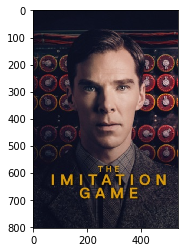

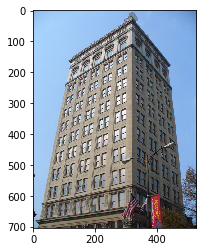

In [6]:
poster_small = cv2.resize(plt.imread("poster.jpg"),None,fx=.5,fy=.5)
poster_medium = cv2.resize(plt.imread("poster.jpg"),None,fx=2,fy=2)
poster_large = cv2.resize(plt.imread("poster.jpg"),None,fx=4,fy=4)
building = plt.imread("griest.jpg")
plt.imshow(poster_medium)
plt.show()
plt.imshow(building)
plt.show()

building_points = np.asarray([
            [104, 247],
            [315, 120],
            [32, 622],
            [313, 564],
        ])
# Small homograhpy
points_small = np.asarray([
           [0,0],
           [poster_small.shape[1]-1, 0],
           [0, poster_small.shape[0]-1],
           [poster_small.shape[1]-1, poster_small.shape[0]-1]
          ])
H_small = find_homography(points_small, building_points)
# Medium homograhpy
points_medium = np.asarray([
           [0,0],
           [poster_medium.shape[1]-1, 0],
           [0, poster_medium.shape[0]-1],
           [poster_medium.shape[1]-1, poster_medium.shape[0]-1]
          ])
H_medium = find_homography(points_medium, building_points)
# Large homograhpy
points_large = np.asarray([
           [0,0],
           [poster_large.shape[1]-1, 0],
           [0, poster_large.shape[0]-1],
           [poster_large.shape[1]-1, poster_large.shape[0]-1]
          ])
H_large = find_homography(points_large, building_points)


In [7]:
small = apply_homography_1(poster_small, H_small,building)
medium = apply_homography_1(poster_medium, H_medium, building)
large = apply_homography_1(poster_large, H_large, building)

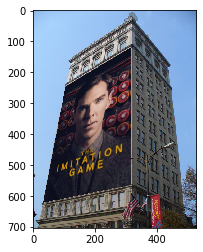

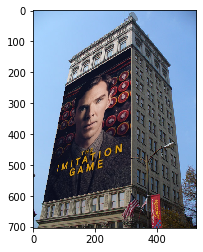

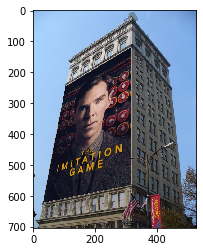

In [8]:
plt.imshow(small)
plt.show()
plt.imshow(medium)
plt.show()
plt.imshow(large)
plt.show()

# Question 3
The file fifaimages.zip contains a template image, and 12 test images of that template undergoing
various distortions. Let’s assume that the nonlinear distortions, e.g. due to the nonrigid warping of cloth,
are negligible and that the template image can be transformed with a homography to fit each test image.
The task is to find those homographies. The file also contains 12 text files. Each of these has an n × 4
matrix that gives the SIFT feature matches between the template and a particular test image. A row in
this matrix is of the form [x y x 0 y 0 ] and indicates that point (x, y) in the template matches with point
(x 0 , y 0 ) in the test image. Note that coordinates are (x, y)-pairs, not (row, column)-pairs.
## 3a
Display every test image and plot the given matches on top of it. A possibility here is to display
the template in the top-left corner of a test image, as in Fig. 1 below.


In [103]:
def apply_homography_2(a, h, target):
    r, c, col = np.shape(a)
    # Determine size of output image by forward-transforming the four corners of A
    p1_h, p2_h, p3_h, p4_h = np.array([[0], [0], [1]], dtype=np.float), \
                             np.array([[c - 1], [0], [1]], dtype=np.float), \
                             np.array([[0], [r - 1], [1]], dtype=np.float), \
                             np.array([[c - 1], [r - 1], [1]], dtype=np.float)

    # Apply homography on each point
    p1, p2, p3, p4 = np.dot(h, p1_h), np.dot(h, p2_h), np.dot(h, p3_h), np.dot(h, p4_h)
    p1, p2, p3, p4 = p1 / p1[2, 0], p2 / p2[2, 0], p3 / p3[2, 0], p4 / p4[2, 0]

    # Get new min and max from each axis
    min_x = floor(min([p1[0, 0], p2[0, 0], p3[0, 0], p4[0, 0]]))
    max_x = ceil(max([p1[0, 0], p2[0, 0], p3[0, 0], p4[0, 0]]))
    min_y = floor(min([p1[1, 0], p2[1, 0], p3[1, 0], p4[1, 0]]))
    max_y = ceil(max([p1[1, 0], p2[1, 0], p3[1, 0], p4[1, 0]]))

    # Obtain new row and column
    nr, nc = max_y - min_y + 1, max_x - min_x + 1

    # Initialize new array with black and then some background
    b = np.zeros([int(nr), int(nc), int(col)]) + 256

    # Pre-compute inverse of H
    h_inv = np.linalg.inv(h)

    pts_src = []
    pts_dst = []
    # Define function on coordinates
    for y in range(int(nr)):
        for x in range(int(nc)):
            p = np.array([[x + min_x], [y + min_y], [1]])
            pp = np.dot(h_inv, p)

            # De-homogenize
            xp, yp = pp[0, 0] / pp[2, 0], pp[1, 0] / pp[2, 0]

            # Interpolate
            xpf, ypf = int(floor(xp)), int(floor(yp))
            xpc, ypc = xpf + 1, ypf + 1

            # Placing the pixels in new image
            if (xpf >= 0) and (xpc < c) and (ypf >= 0) and (ypc < r):
                b[y, x, :] = ((xpc - xp) * (ypc - yp) * a[ypf, xpf, :]
                              + (xpc - xp) * (yp - ypf) * a[ypc, xpf, :]
                              + (xp - xpf) * (ypc - yp) * a[ypf, xpc, :]
                              + (xp - xpf) * (yp - ypf) * a[ypc, xpc, :])
                pts_src.append([yp, xp])
                pts_dst.append([y+min_y, x+min_x])
    x_min = int(min_x)
    y_min = int(min_y)
    tmp = b.astype(np.uint8)
    base = np.zeros_like(target)
    mask = tmp[:,:,:] == [256,256,256]
    for r in range(0, mask.shape[0]):
        for c in range(0, mask.shape[1]):
            if mask[r,c,1] == False:
                base[r+y_min][c+x_min] = tmp[r,c,:]
    mask = base ==[0,0,0]
    un_mask = np.invert(mask)
    base[mask] = target[mask]
#     return base.astype(np.uint8), pts_src, pts_dst, int(min_x),int(min_x)
    return base.astype(np.uint8)

def draw_matches(matches, test_image, template):
    mask = np.zeros_like(test_image, dtype=bool)
    mask[:template.shape[0],:template.shape[1],:] = True
    un_mask = np.invert(mask)
    out_image = np.zeros_like(test_image)
    out_image[un_mask] = test_image[un_mask]
    for x in range(0, template.shape[0]):
        for y in range(0, template.shape[1]):
            out_image[x,y,:] = template[x,y,:]
    # Draw points
    for m in matches:
        cv2.circle(out_image,(m[0],m[1]), 3, colour, thickness=1, lineType=8, shift=0)
        cv2.circle(out_image,(m[2],m[3]), 3, colour, thickness=1, lineType=8, shift=0)
        cv2.line(out_image, (m[0],m[1]), (m[2],m[3]), colour, thickness=2, lineType=8)
    
    # Show Images     
    plt.imshow(out_image)
    plt.show()

def get_good_matches(matches, threshold):
    end_points = matches[:, 2:4]
    start_points = matches[:, 0:2]
    good_matches = []
    for i in range(0, len(matches)):
        for j in range(i, len(matches)):
#             p1 = end_points[random.randrange(0, len(matches), 1)]
#             p2 = end_points[random.randrange(0, len(matches), 1)]
            p1 = end_points[i]
            p2 = end_points[j]
            p_1 = start_points[i]
            p_2 = start_points[j]
            distance = np.abs(np.cross(p2-p1, p1-end_points)) / np.linalg.norm(p2-p1)
            distance_1 = np.abs(np.cross(p_2-p_1, p_1-start_points)) / np.linalg.norm(p_2-p_1)
            distance = distance[:] < threshold
            distance_1 = distance_1[:]<threshold/2
            wololo =  np.logical_and(distance,distance_1)
            tmp_matches = matches[wololo]
            if len(tmp_matches) > len(good_matches):
                good_matches = tmp_matches
    return good_matches

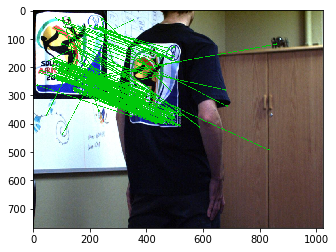

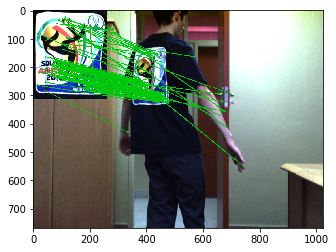

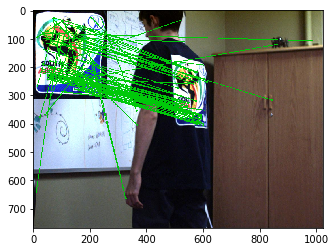

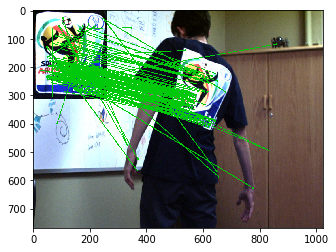

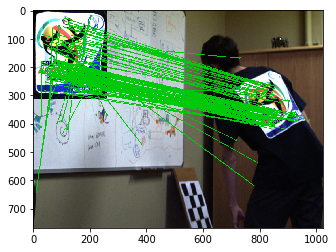

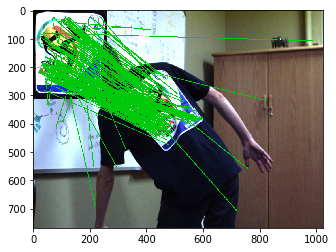

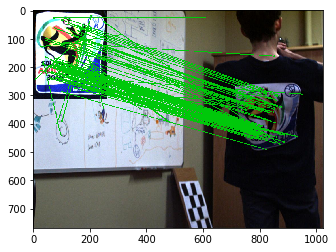

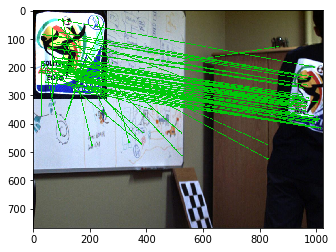

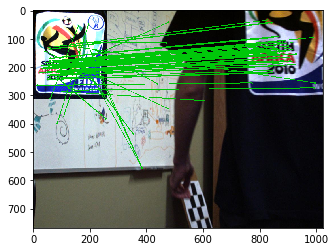

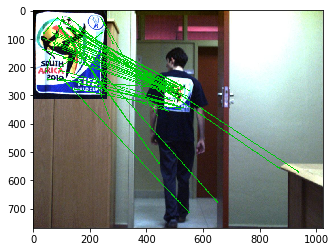

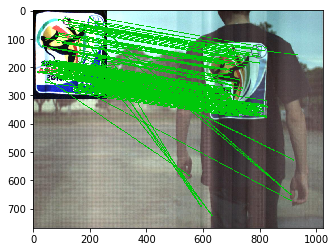

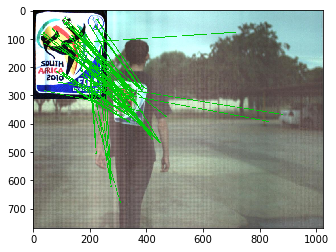

In [115]:
template = plt.imread("fifa/template.jpg")
corners = np.asarray([
           [0,0],
           [template.shape[1]-1, 0],
           [0, template.shape[0]-1],
           [template.shape[1]-1, template.shape[0]-1]
          ])
colour = (0,200,10)
for i in range(1, 13):
    matches = pd.read_csv(f"fifa/fifasiftmatches/siftmatches_{i}.txt", sep="\s+", header=None)
    matches = np.asarray(matches, dtype=int)
    test_image = plt.imread(f"fifa/{i}.jpg")
    draw_matches(matches, test_image, template)


## 3b
Implement a RANSAC based approach to find a set of inlier feature matches and a homography
calculated from them, for each test image. Display for every test image the inlier matches found, as
in Fig. 2. Also map the four corners of the template with your calculated homography and draw the
resulting quadrilateral on top of the test image, as in Fig. 3.

/home/19059019/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide
/home/19059019/.local/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
/home/19059019/.local/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in less
/home/19059019/.local/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in less


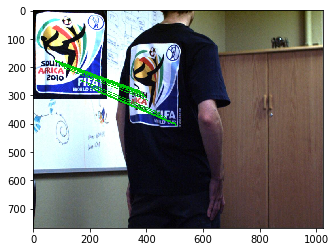

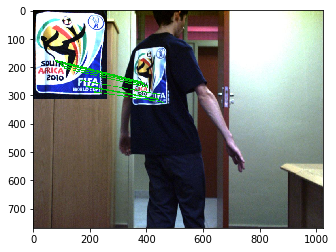

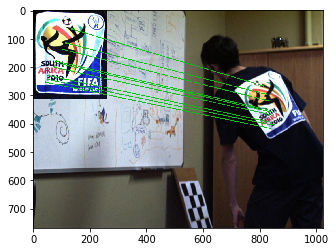

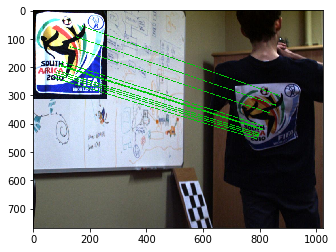

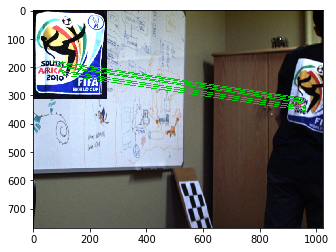

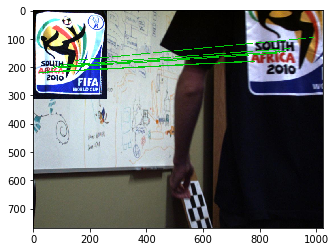

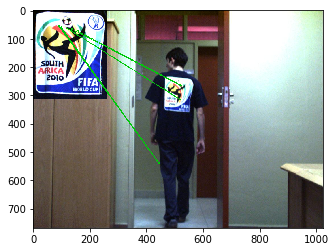

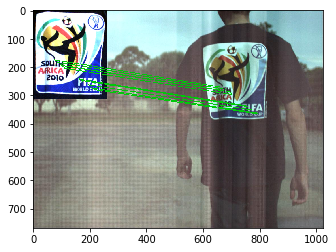

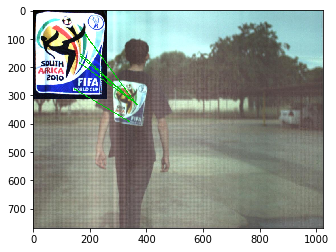

In [100]:
for i in range(1, 13):
    matches = pd.read_csv(f"fifa/fifasiftmatches/siftmatches_{i}.txt", sep="\s+", header=None)
    matches = np.asarray(matches, dtype=int)
    test_image = plt.imread(f"fifa/{i}.jpg")
    matches = get_good_matches(matches, 10)
    draw_matches(matches, test_image, template)
    

/home/19059019/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide
/home/19059019/.local/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
/home/19059019/.local/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in less
/home/19059019/.local/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in less


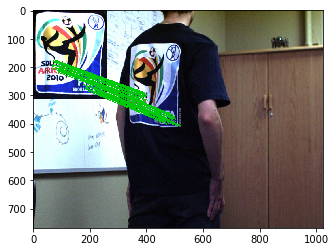

[array([225, 262, 497, 376]), array([207, 249, 479, 363]), array([ 71, 193, 368, 299]), array([104, 196, 399, 307])]


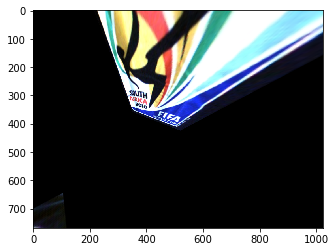

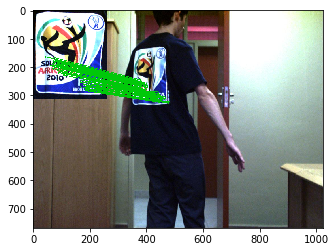

[array([ 74, 167, 380, 246]), array([189, 279, 438, 320]), array([228, 286, 466, 322]), array([111, 205, 404, 272])]


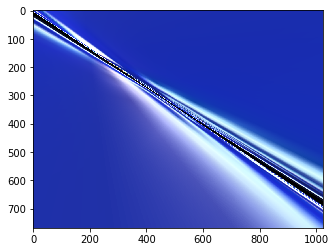

In [95]:
matches = pd.read_csv(f"fifa/fifasiftmatches/siftmatches_1.txt", sep="\s+", header=None)
matches = np.asarray(matches, dtype=int)
test_image = plt.imread(f"fifa/1.jpg")
    
matches = get_good_matches(matches,20)
draw_matches(matches, test_image, template)
H = estimate_homography(matches)

matches = pd.read_csv(f"fifa/fifasiftmatches/siftmatches_2.txt", sep="\s+", header=None)
matches = np.asarray(matches, dtype=int)
test_image = plt.imread(f"fifa/2.jpg")
    
matches = get_good_matches(matches,20)
draw_matches(matches, test_image, template)
H = estimate_homography(matches)


In [153]:
def estimate_homography(matches):
    """
    1. repeat many times:
        1.1 choose 4 matches randomly
        1.2 calculate H (as we did in Lecture 10)
        1.3 map every (x i , y i ) with H, and compare with its match (x i 0 , y i 0 );
            those close enough form the consensus set
    2. pick the largest consensus set found: this is our set of inliers
    3. re-estimate H in a least-squares sense, using the entire set of inliers
    """
    test_matches = np.float32(matches[:,0:2]).reshape(-1,1,2)
    test_results = np.float32(matches[:,2:4]).reshape(-1,1,2)
    best_H = []
    best_count = 0
    for i in range(0, 100):
        r1 = random.randrange(0, len(matches), 1)
        r2 = random.randrange(0, len(matches), 1)
        r3 = random.randrange(0, len(matches), 1)
        r4 = random.randrange(0, len(matches), 1)
        ran_matches = np.array([
            matches[r1],
            matches[r2],
            matches[r3],
            matches[r4],
        ])
        H = find_homography(ran_matches[:, 0:2],ran_matches[:, 2:4])
        count = 0
        trans = cv2.perspectiveTransform(test_matches, H)
        for i in range(0, len(trans)):
            start = (trans[i][0][0],trans[i][0][0])
            end = (test_results[i][0][0],test_results[i][0][0])
            dist = math.sqrt((start[0] - end[0]*1.0)**2 + (start[1] - end[1]*1.0)**2)
            if dist < 5:
                count += 1
            if count > best_count:
                best_count = count
                best_H = H
        
        
    return best_H

/home/19059019/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide
/home/19059019/.local/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
/home/19059019/.local/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in less
/home/19059019/.local/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in less


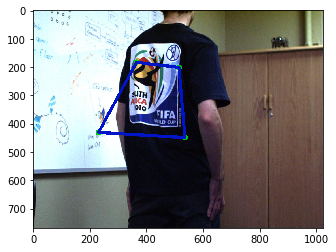

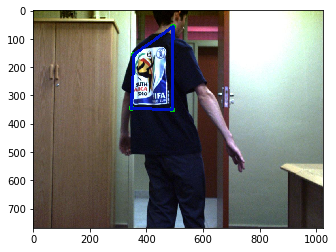

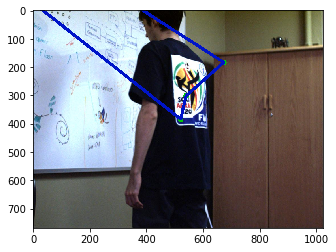

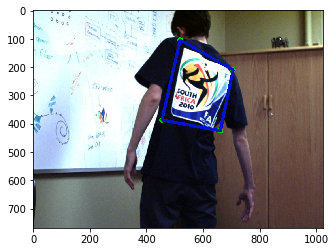

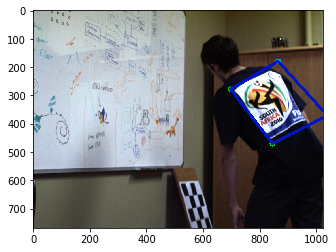

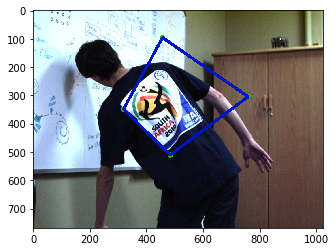

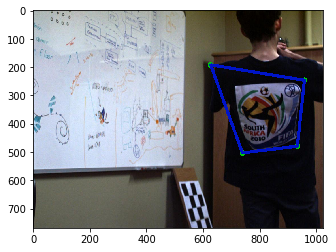

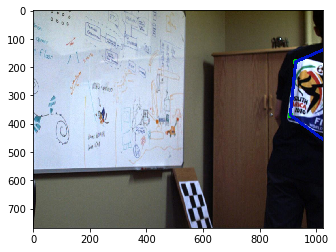

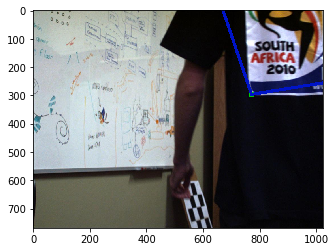

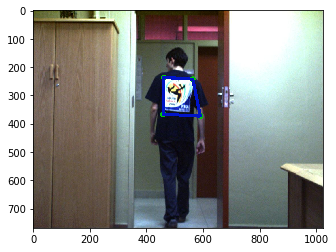

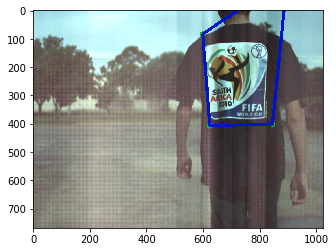

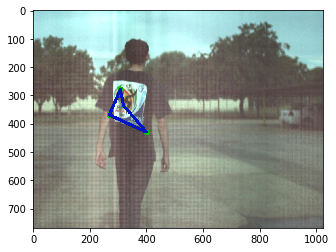

In [154]:
template = plt.imread("fifa/template.jpg")
corners = np.asarray([
           [0,0],
           [template.shape[1]-1, 0],
           [0, template.shape[0]-1],
           [template.shape[1]-1, template.shape[0]-1]
          ])

for i in range(1, 13):
    matches = pd.read_csv(f"fifa/fifasiftmatches/siftmatches_{i}.txt", sep="\s+", header=None)
    matches = np.asarray(matches, dtype=int)
    test_image = plt.imread(f"fifa/{i}.jpg")
    matches = get_good_matches(matches, 40)
    H = estimate_homography(matches)
    corners = np.float32(corners).reshape(-1,1,2)
    corners_1 = cv2.perspectiveTransform(corners, H)
    for i in range(0, 4):
        cv2.circle(test_image,(corners_1[i][0][0],corners_1[i][0][1]), 10, colour, thickness=-1, lineType=8, shift=0)
    
    cv2.line(test_image, (corners_1[0][0][0], corners_1[0][0][1]), (corners_1[1][0][0], corners_1[1][0][1]), (0, 20, 200), 10)
    cv2.line(test_image, (corners_1[0][0][0], corners_1[0][0][1]), (corners_1[2][0][0], corners_1[2][0][1]), (0, 20, 200), 10)
    cv2.line(test_image, (corners_1[3][0][0], corners_1[3][0][1]), (corners_1[2][0][0], corners_1[2][0][1]), (0, 20, 200), 10)
    cv2.line(test_image, (corners_1[3][0][0], corners_1[3][0][1]), (corners_1[1][0][0], corners_1[1][0][1]), (0, 20, 200), 10)
    
    plt.imshow(test_image)
    plt.show()

[True, True] [False, True] [False, True]


True